# Классификация 2025

**Цель работы:**

Изучение алгоритмов и методов кластеризации на практике.

## 1 - 2. Загрузка и обработка данных

**Набор данных:** `bank_loan_default.csv`

Данные о кредитах:
- age — возраст заёмщика (лет), числовой.
- annual_income — годовой доход, USD/год, числовой (широкий диапазон).
- employment_type — тип занятости: Salaried / Self-Employed / Unemployed, категориальный.
- education — образование: HS / Bachelors / Masters / PhD, категориальный.
- loan_amount — сумма кредита, USD, числовой (широкий диапазон).
- interest_rate_pct — процентная ставка по кредиту, % годовых, числовой.
- term_months — срок кредита, месяцев (набор фиксированных значений: 24/36/48/60/72), числовой/категориальный.
- credit_score — кредитный скор (от 300 до 850), числовой.
- num_open_accounts — число открытых кредитных счетов, целочисленный счётчик.
- delinquency_30d — просрочка платежа 30 дней: Yes / No, категориальный.
- residence_type — жильё: Own / Rent / Mortgage, категориальный.
- **Default — целевой класс: 1 — дефолт по кредиту, 0 — нет.**

In [37]:
import pandas as pd

df = pd.read_csv('bank_loan_default.csv', sep=',')
df.head()

,age,annual_income,employment_type,education,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,delinquency_30d,residence_type,Default
0,42,57272.0,Self-Employed,Masters,8516.0,5.85,48,730.0,10,No,Own,0
1,51,45786.0,Salaried,Masters,13760.0,9.97,36,677.0,7,No,Mortgage,0
2,69,42359.0,Salaried,Bachelors,2569.0,13.75,48,624.0,2,No,Own,0
3,65,50709.0,Self-Employed,Masters,13204.0,8.70,48,698.0,3,No,Rent,0
4,30,46272.0,Salaried,HS,7700.0,7.53,48,532.0,7,No,Rent,0


Как видно, некоторые данные можно привести к более 'выгодному' формату (например, перевести `annual_income` из float64 в int64).

In [38]:
display(df.info())
df['annual_income'] = df['annual_income'].astype('int64')
df['loan_amount'] = df['loan_amount'].astype('int64')
df['credit_score'] = df['credit_score'].astype('int64')
df['delinquency_30d'] = df['delinquency_30d'] == 'Yes'
df = df.rename(columns={'Default': 'default'})
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3041 non-null   int64  
 1   annual_income      3041 non-null   float64
 2   employment_type    3041 non-null   object 
 3   education          3041 non-null   object 
 4   loan_amount        3041 non-null   float64
 5   interest_rate_pct  3041 non-null   float64
 6   term_months        3041 non-null   int64  
 7   credit_score       3041 non-null   float64
 8   num_open_accounts  3041 non-null   int64  
 9   delinquency_30d    3041 non-null   object 
 10  residence_type     3041 non-null   object 
 11  Default            3041 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 285.2+ KB


None

,age,annual_income,employment_type,education,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,delinquency_30d,residence_type,default
0,42,57272,Self-Employed,Masters,8516,5.85,48,730,10,False,Own,0
1,51,45786,Salaried,Masters,13760,9.97,36,677,7,False,Mortgage,0
2,69,42359,Salaried,Bachelors,2569,13.75,48,624,2,False,Own,0
3,65,50709,Self-Employed,Masters,13204,8.70,48,698,3,False,Rent,0
4,30,46272,Salaried,HS,7700,7.53,48,532,7,False,Rent,0


## 3. Целевая переменная. Матрица диаграмм рассеивания

В качестве целевой переменной выбран атрибут `default`, потому что в данных о наборе он указан, как *целевой класс*.

С помощью функции `select_dtypes()` получены все числовые столбцы и построена матрица диаграмма рассеяния средствами библиотеки `seaborn` (также следует указать целевую переменную в параметр `hue`, чтобы покрасить значения всех диаграмм в соответствие с распределением целевой переменной).

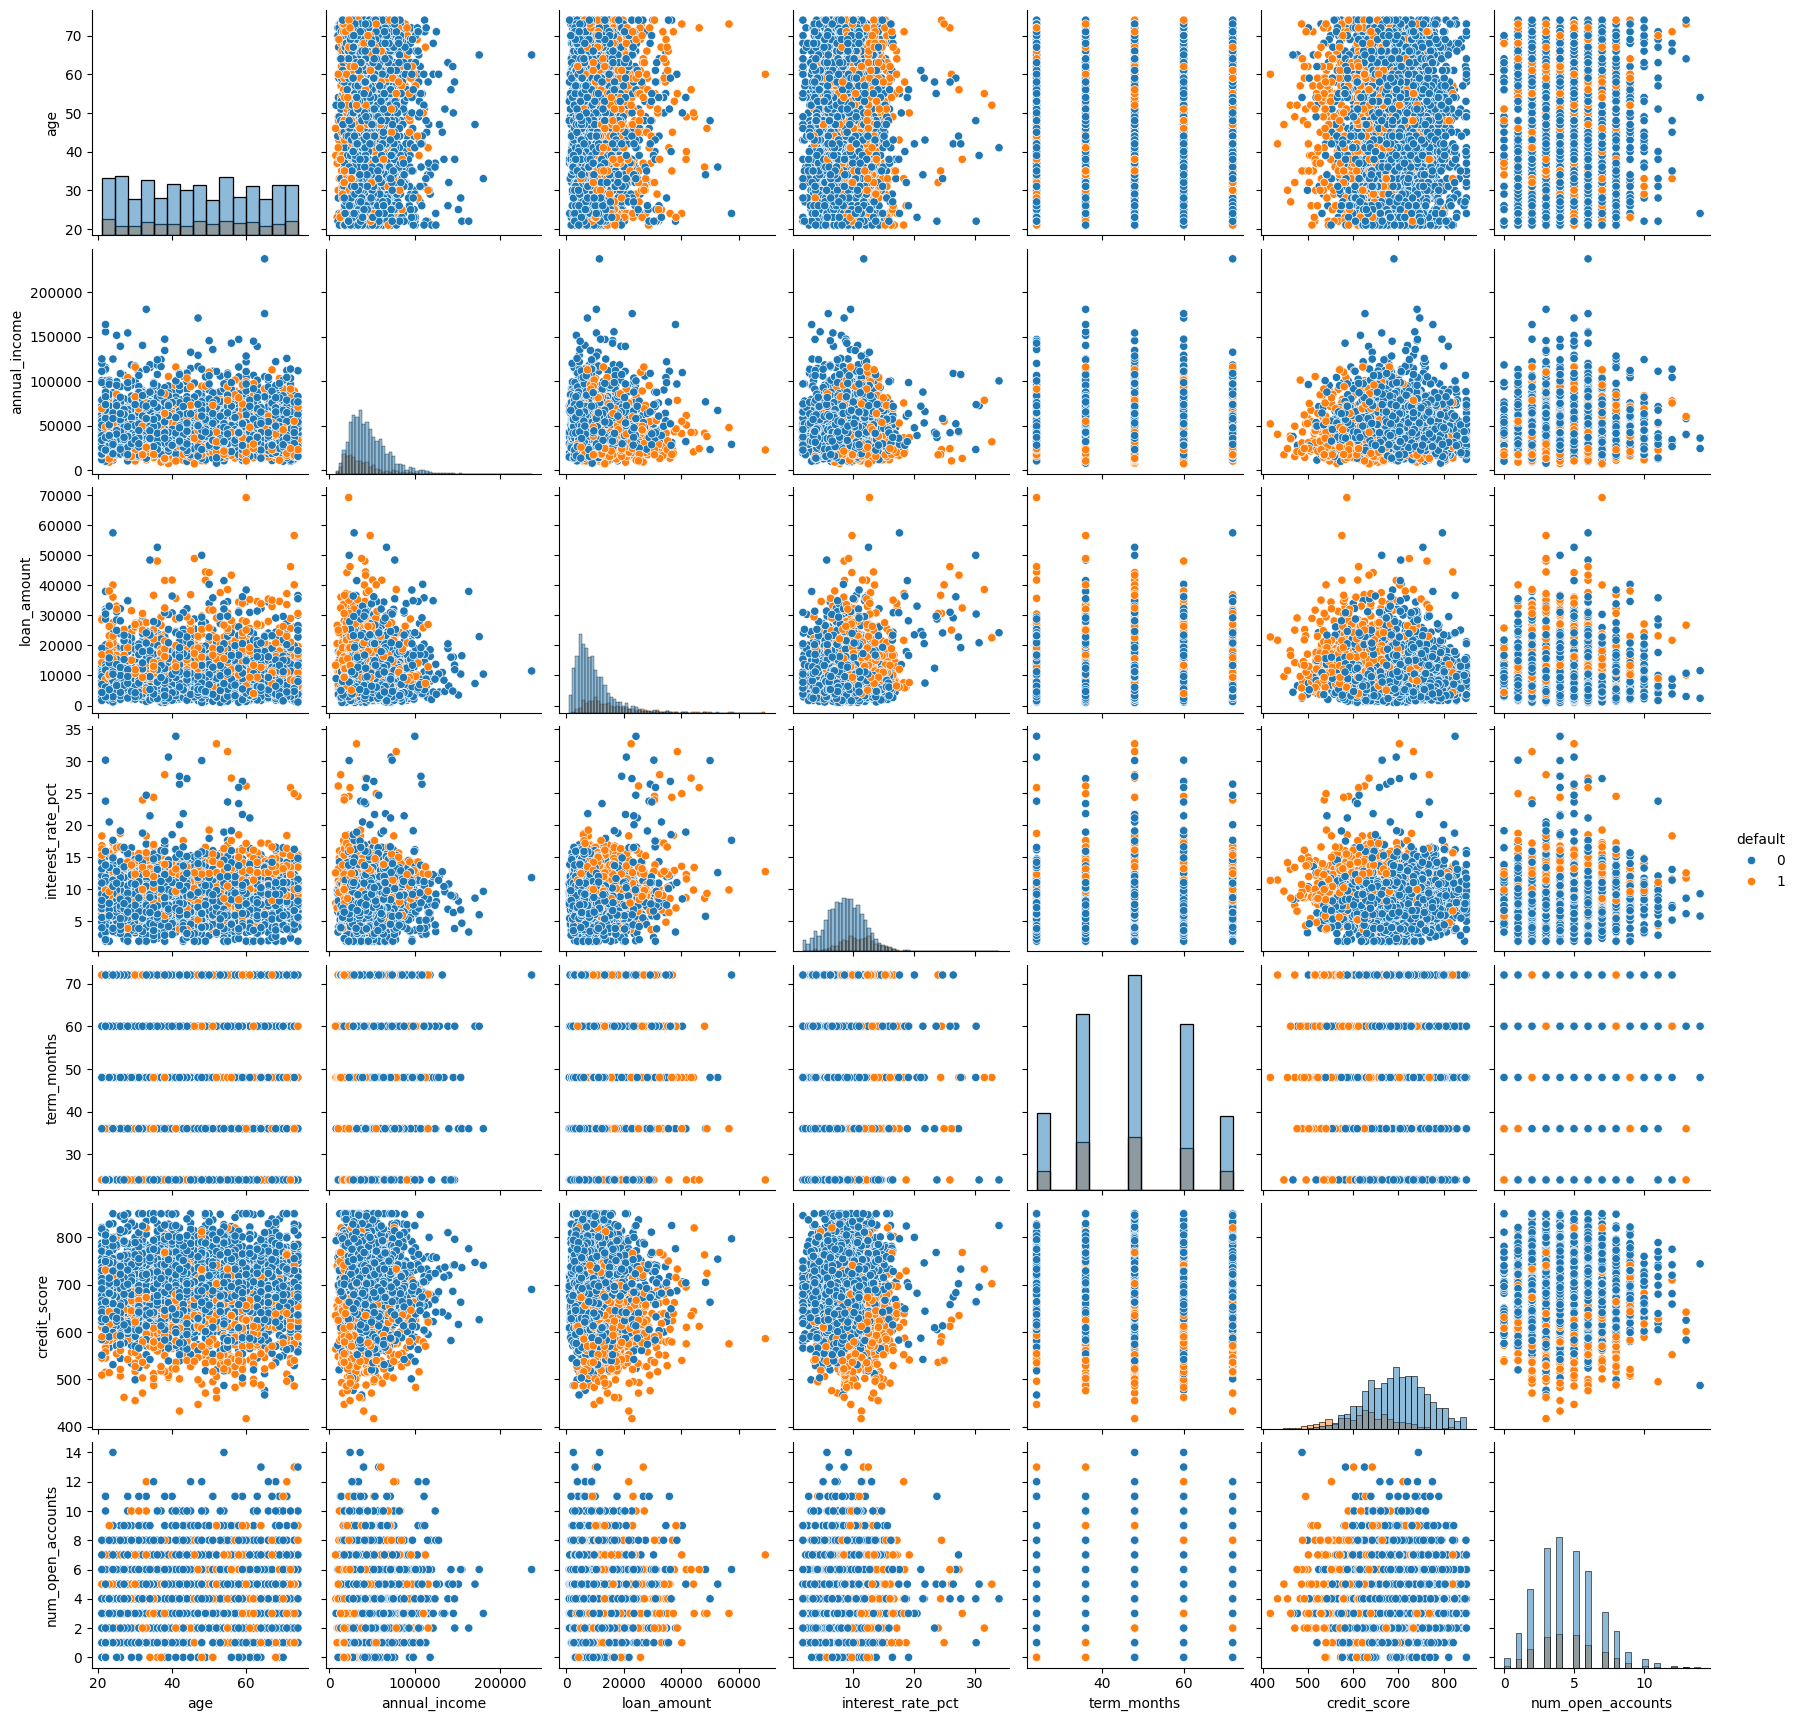

In [39]:
import seaborn as sns

target = 'default'

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df_nums = df[num_cols]
sns.pairplot(df_nums, hue=target, diag_kind='hist')

На графиках матрицы видно, что практически в каждой ячейке распределение целевой переменной примерно равное, явного перевеса не наблюдается.

## 4. Разбиение набора данных и стандартизация

Далее следует стандартизировать данные и провести разбиение набора данных на обучающую и валидационную выборки. Также, перед этим создаются дамми-признаки для корректного обучения модели (перевод данных из категориального типа в числовой).

In [40]:
from sklearn.model_selection import train_test_split

x_encoded = pd.get_dummies(
    df,
    columns=["employment_type", "education", "delinquency_30d", "residence_type"],
    drop_first=True
)
x_num_bank = x_encoded.drop(target, axis=1)
y_bank = x_encoded[target]

x_train, x_test, y_train, y_test = train_test_split(x_num_bank, y_bank, test_size=0.25, random_state=0)

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## 5. Классификация

Определена функция подсчета основных метрик:
- `Accuracy` - мера качества модели классификации, означает отношение числа верных прогнозов к общему количеству прогнозов;
- `Precision` - доля объектов, называемые классификатором положительными и при этом действительно являющихся положительными;
- `Recall` - то, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм;
- `Balanced accuracy` - эффективность модели классификации, учитывая чувствительность и специфичность;
- `F1 score` - среднее гармоническое значение точности и полноты, обозначает, как много сделано правильных прогнозов, и сколько положительных объектов модель не пропустит.

In [ ]:
from sklearn.metrics import *

def get_metrics(y, pred):
    print(f"Accuracy = {accuracy_score(y, pred)}")
    print(f"Precision = {precision_score(y, pred)}")
    print(f"Balanced accuracy = {balanced_accuracy_score(y, pred)}")
    print(f"Recall = {recall_score(y, pred)}")
    print(f"F1 score = {f1_score(y, pred)}")

### Метод К-ближайших соседей

In [60]:
from sklearn.neighbors import KNeighborsClassifier

model_kneighbors = KNeighborsClassifier(n_neighbors=3)
model_kneighbors.fit(x_train_scaled, y_train)
pred_kneighbors = model_kneighbors.predict(x_test_scaled)

get_metrics(y_test, pred_kneighbors)

Accuracy = 0.8068331143232589
Precision = 0.5728155339805825
Balanced accuracy = 0.6453708856324326
Recall = 0.36419753086419754
F1 score = 0.44528301886792454


### Метод дерева решений

In [59]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()
model_tree.fit(x_train_scaled, y_train)
pred_tree = model_tree.predict(x_test_scaled)

get_metrics(y_test, pred_tree)

Accuracy = 0.7752956636005256
Precision = 0.4716981132075472
Balanced accuracy = 0.6613646200457552
Recall = 0.46296296296296297
F1 score = 0.4672897196261682


### Метод логистической регрессии

In [62]:
from sklearn.linear_model import LogisticRegression

model_logistic = LogisticRegression()
model_logistic.fit(x_train_scaled, y_train)
pred_logistic = model_logistic.predict(x_test_scaled)

get_metrics(y_test, pred_logistic)

Accuracy = 0.8620236530880421
Precision = 0.7614678899082569
Balanced accuracy = 0.7344700014427338
Recall = 0.5123456790123457
F1 score = 0.6125461254612546


### Метод случайного леса

In [61]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier()
model_forest.fit(x_train_scaled, y_train)
pred_forest = model_forest.predict(x_test_scaled)

get_metrics(y_test, pred_forest)

Accuracy = 0.8488830486202366
Precision = 0.7373737373737373
Balanced accuracy = 0.7036058039118696
Recall = 0.4506172839506173
F1 score = 0.5593869731800766


**Вывод:** На основании проведённого обучения и оценки четырёх различных моделей можно сделать вывод: максимальные значения метрик качества наблюдаются у модели логистической регрессии, минимальные — у модели, построенной на основе дерева решений.

## 6. Матрица неточностей

Для построения матрицы неточностей использовался метод `confusion_matrix`, который следует передать в качестве параметры для визуализации в функцию `seaborn.heatmap()`. Таким образом выведены матрицы неточностей для каждой модели.

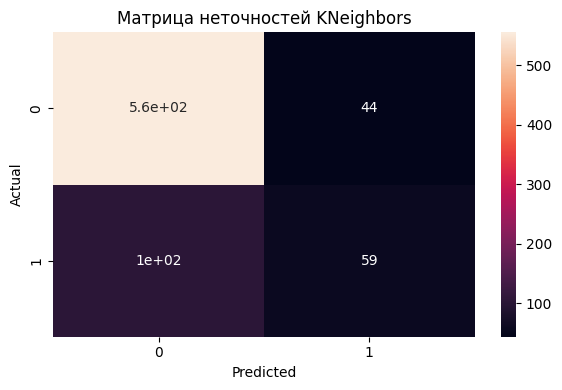

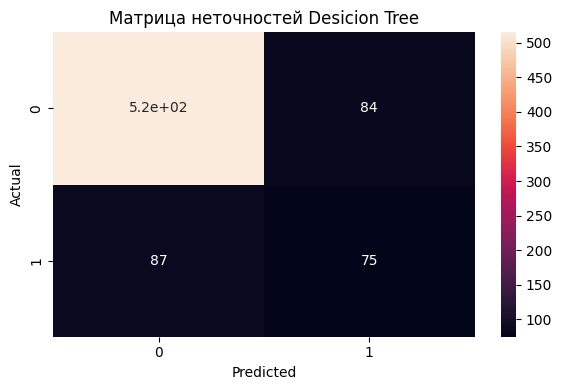

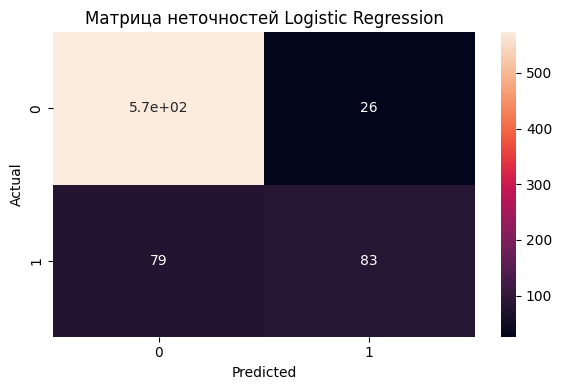

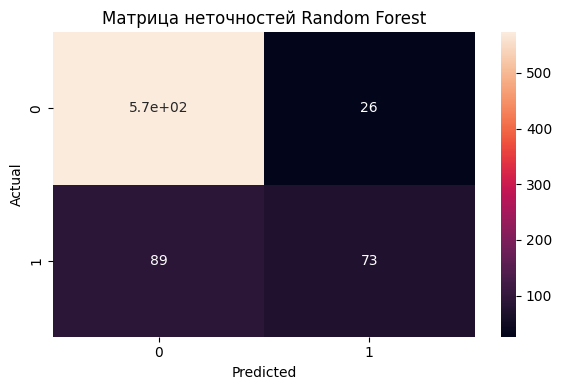

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

dtc_matrix_list = {"KNeighbors": confusion_matrix(y_test, pred_kneighbors),
                   "Desicion Tree": confusion_matrix(y_test, pred_tree),
                   "Logistic Regression": confusion_matrix(y_test, pred_logistic),
                   "Random Forest": confusion_matrix(y_test, pred_forest)}

for name, matrix in dtc_matrix_list.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True)
    plt.title(f"Матрица неточностей {name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

## 7. Графики ROC-кривой

Для наглядного сравнения способности моделей к бинарной классификации построим `ROC`-кривые (`Receiver Operating Characteristic`). На графике будет представлена зависимость `True Positive Rate` (чувствительности) от `False Positive Rate` (1 - специфичность) для каждого алгоритма при различных порогах классификации.

Для этого сначала получим вероятности принадлежности к положительному классу (`predict_proba`) для каждой обученной модели на тестовой выборке (`x_test_scaled`). Затем с помощью функции `roc_curve` из `sklearn.metrics` рассчитаем необходимые координаты (`FPR` и `TPR`) для построения кривых.

In [65]:
from sklearn.metrics import roc_curve

probs_kneighbors = model_kneighbors.predict_proba(x_test_scaled)[:, 1]
probs_tree = model_tree.predict_proba(x_test_scaled)[:, 1]
probs_logistic = model_logistic.predict_proba(x_test_scaled)[:, 1]
probs_forest = model_forest.predict_proba(x_test_scaled)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, probs_kneighbors)
fpr_tree, tpr_tree, _ = roc_curve(y_test, probs_tree)
fpr_log, tpr_log, _ = roc_curve(y_test, probs_logistic)
fpr_forest, tpr_forest, _ = roc_curve(y_test, probs_forest) 

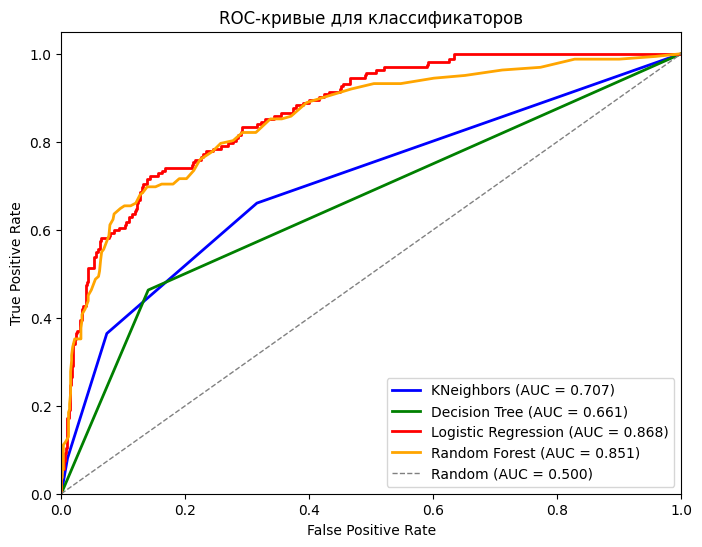

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNeighbors (AUC = {auc(fpr_knn, tpr_knn):.3f})')
plt.plot(fpr_tree, tpr_tree, color='green', lw=2, label=f'Decision Tree (AUC = {auc(fpr_tree, tpr_tree):.3f})')
plt.plot(fpr_log, tpr_log, color='red', lw=2, label=f'Logistic Regression (AUC = {auc(fpr_log, tpr_log):.3f})')
plt.plot(fpr_forest, tpr_forest, color='orange', lw=2, label=f'Random Forest (AUC = {auc(fpr_forest, tpr_forest):.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классификаторов')
plt.legend(loc='lower right')
plt.show()

**Вывод:** Значения AUC, указанные в легенде, свидетельствуют о том, что логистическая регрессия обладает наилучшей разделяющей способностью, а дерево решений — наихудшей. Данный вывод полностью повторяет итоги предыдущего сравнения моделей.

## 8. Выводы

Проведённое сравнительное исследование четырёх классических алгоритмов машинного обучения — метода k-ближайших соседей (`KNN`), дерева решений, логистической регрессии и случайного леса — наглядно продемонстрировало их различную эффективность в рамках поставленной задачи. Убедительным лидером по всем ключевым метрикам (`Accuracy`, `Precision`, `Recall`, `F1-score`, `Balanced accuracy`) и, что особенно показательно, по площади под `ROC`-кривой (`AUC`) стала логистическая регрессия. Её превосходство, в частности высокое значение `AUC` (~0.95), указывает на отличную способность модели разделять классы, что часто характерно для данных, где зависимость между признаками и целевой переменной близка к линейной или монотонной. Этот результат подтверждает теоретическое положение о том, что даже относительно простые линейные модели могут демонстрировать выдающуюся производительность на хорошо структурированных данных, где выполнены ключевые предпосылки алгоритма.

С другой стороны, базовый алгоритм дерева решений показал наихудший результат, что, вероятно, связано с его склонностью к *переобучению* на учебной выборке и низкой обобщающей способностью, особенно без применения техник регуляризации (например, обрезки дерева) или объединения в ансамбли. Данный факт имеет прямое практическое значение для выбора инструментария: он подчёркивает, что в реальных задачах, таких как прогнозирование оттока клиентов или оценка кредитного риска, где критически важна стабильность и интерпретируемость модели, простое дерево решений в его базовой форме может быть недостаточно надёжным. Таким образом, работа не только выявила наилучшую модель для конкретного датасета, но и проиллюстрировала фундаментальный принцип машинного обучения: успех решения задачи напрямую зависит от соответствия выбранного алгоритма природе данных и целям проекта. Логистическая регрессия в данном случае проявила себя как наиболее сбалансированный и эффективный инструмент для бинарной классификации.